# Stock Price Prediction Using Machine Learning

In this project, we will predict stock prices using machine learning techniques. The goal is to predict the future price of a stock based on historical data. We will leverage libraries like `yfinance` for fetching stock data, `PyTorch` for building a deep learning model, and `sklearn` for data preprocessing.

## Libraries Used

1. **yfinance**: Used to fetch historical stock price data.
2. **NumPy**: Used for numerical operations.
3. **Pandas**: For data manipulation and analysis.
4. **Matplotlib**: For visualizing stock data and model predictions.
5. **PyTorch**: For building and training deep learning models.
6. **scikit-learn**: For data preprocessing and performance metrics.

We will implement a simple neural network model to predict the stock price, train it using the historical stock data, and then evaluate its performance.

---

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [2]:
# See device type (where the device will be computing the request)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# This will show 'cuda' if a GPU is available, otherwise 'cpu'
device

device(type='cpu')

## Stock Data Retrieval with Yahoo Finance

In this section, we are retrieving historical stock price data for the company with the ticker symbol `ASII.JK` (Astra International Tbk) using the `yfinance` library.

The function `yf.download()` is used to download the stock data, and the following options are set:

- **`ticker = 'ASII.JK'`**: This specifies the ticker symbol for Astra International Tbk on the Jakarta Stock Exchange (JK).
- **`auto_adjust = False`**: This option ensures that the data retrieved will not have any adjustments made to the historical prices (such as stock splits or dividends). If `auto_adjust` was set to `True`, the data would be adjusted to reflect those corporate actions.
- **`timeout = 60`**: This sets a timeout period of 60 seconds for the request to complete. If the request to Yahoo Finance takes longer than this, it will be interrupted and an error will be raised.

This data will include various stock price attributes like Open, High, Low, Close, Volume, and Adjusted Close. 

Once retrieved, the data will be stored in the variable `df`, which we can then use for further analysis, visualizations, or machine learning tasks.

In [3]:
ticker = 'ASII.JK'
df = yf.download(ticker ,auto_adjust = False, timeout=60)

[*********************100%***********************]  1 of 1 completed


In [4]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,ASII.JK,ASII.JK,ASII.JK,ASII.JK,ASII.JK,ASII.JK
Date,,,,,,
2000-10-17,75.432701,187.792114,192.815369,187.405716,189.724136,30266285
2000-10-18,73.104500,181.996063,188.951324,181.609665,187.792114,45082402
2000-10-19,74.811844,186.246506,187.405716,179.291245,183.928085,43730189
2000-10-20,71.397217,177.745636,195.133789,175.813614,193.201767,212012808
2000-10-23,70.621140,175.813614,181.609665,173.881592,177.745636,84723602
...,...,...,...,...,...,...
2025-06-23,4430.000000,4430.000000,4470.000000,4400.000000,4470.000000,28820000
2025-06-24,4470.000000,4470.000000,4500.000000,4430.000000,4470.000000,37523200


<Axes: xlabel='Date'>

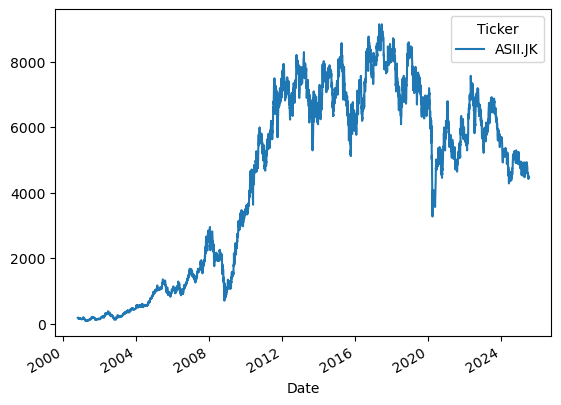

In [5]:
df.Close.plot()

In [6]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])


In [7]:
df.Close


Ticker,ASII.JK
Date,
2000-10-17,-1.478022
2000-10-18,-1.480049
2000-10-19,-1.478562
2000-10-20,-1.481536
2000-10-23,-1.482212
...,...
2025-06-23,0.005866
2025-06-24,0.019857
2025-06-25,0.019857


In [8]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

data

array([[[-1.47802181],
        [-1.48004922],
        [-1.47856245],
        ...,
        [-1.48288759],
        [-1.48153598],
        [-1.48153598]],

       [[-1.48004922],
        [-1.47856245],
        [-1.48153598],
        ...,
        [-1.48153598],
        [-1.48153598],
        [-1.48221178]],

       [[-1.47856245],
        [-1.48153598],
        [-1.48221178],
        ...,
        [-1.48153598],
        [-1.48221178],
        [-1.48221178]],

       ...,

       [[ 0.11779896],
        [ 0.14578227],
        [ 0.1282927 ],
        ...,
        [ 0.02685322],
        [ 0.00586574],
        [ 0.01985739]],

       [[ 0.14578227],
        [ 0.1282927 ],
        [ 0.1282927 ],
        ...,
        [ 0.00586574],
        [ 0.01985739],
        [ 0.01985739]],

       [[ 0.1282927 ],
        [ 0.1282927 ],
        [ 0.13878644],
        ...,
        [ 0.01985739],
        [ 0.01985739],
        [ 0.01286156]]])

In [9]:

train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1,:]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1,:]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[:train_size, :-1,:]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[:train_size, -1,:]).type(torch.Tensor).to(device)

In [10]:
y_train


tensor([[-1.4815],
        [-1.4822],
        [-1.4822],
        ...,
        [-0.1760],
        [-0.1620],
        [-0.1550]])

## LSTM-based Prediction Model for Stock Price Prediction

This section defines a PyTorch `PredictionModel` class that uses an LSTM (Long Short-Term Memory) network to predict stock prices based on historical data.

### Class Overview:

1. **LSTM Layer**:
   - **`self.lstm`**: The core LSTM layer designed for sequential data like stock prices.
   - **Parameters**: 
     - `input_dim`: Number of input features per time step.
     - `hidden_dim`: Number of features in the hidden state.
     - `num_layers`: Number of stacked LSTM layers.
     - `batch_first=True`: Input shape is `(batch_size, sequence_length, input_dim)`.

2. **Fully Connected (FC) Layer**:
   - **`self.fc`**: A linear layer that transforms LSTM output to the final prediction.

### `forward()` Method

1. **Initialize Hidden and Cell States**: 
   - `h0` and `c0` are initialized to zeros for the hidden and cell states.
   
2. **LSTM Forward Pass**:
   - Input data is passed through the LSTM, and we use the output from the last time step for the final prediction.

3. **Fully Connected Layer**:
   - The LSTM output is passed through the fully connected layer to produce the prediction.

### Output:
- The final output is the predicted stock price or other time series value, based on the trained model.

---

This model is ideal for learning patterns in historical stock data and predicting future price trends.


In [11]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x): 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out
    

## Model Training and Evaluation

In this section, we train and evaluate the `PredictionModel` for predicting stock prices or time series data.

### Steps:

1. **Model Initialization**:
   - The model is initialized with `input_dim=1`, `hidden_dim=32`, `num_layers=2`, and `output_dim=29`. It is moved to the GPU/CPU using `.to(device)`.

2. **Loss Function and Optimizer**:
   - **MSELoss** is used to measure the error, and the **Adam optimizer** is used for parameter updates.

3. **Training Loop**:
   - The model trains for `200` epochs, predicting stock prices and updating weights based on the loss. The loss is printed every 25 epochs.

4. **Evaluation**:
   - After training, the model is set to evaluation mode (`model.eval()`). Predictions are made on the test data (`y_test_pred = model(X_test)`).

5. **Detaching and Conversion**:
   - Predictions and actual values are converted to NumPy arrays for further operations.

6. **Inverse Transformation**:
   - The predicted and actual values are scaled back to their original form using `scaler.inverse_transform()`.

7. **RMSE Calculation**:
   - The RMSE for both training and test sets is computed to evaluate model performance:
     - `train_rmse` and `test_rmse` provide a measure of prediction accuracy, with lower values indicating better performance.

### Final Output:
- **`train_rmse`**: RMSE on the training data.
- **`test_rmse`**: RMSE on the test data.

This section covers model training and its evaluation on the test data.


In [12]:
model = PredictionModel(input_dim = 1, hidden_dim=32, num_layers=2, output_dim=29).to(device)


In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [14]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(f"Epoch [{i}/{num_epochs}], Loss: {loss.item()}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

C:\Users\yajam\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([4891, 1])) that is different to the input size (torch.Size([4891, 29])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [0/200], Loss: 1.1969209909439087
Epoch [25/200], Loss: 0.12858876585960388
Epoch [50/200], Loss: 0.11800079792737961
Epoch [75/200], Loss: 0.019458875060081482
Epoch [100/200], Loss: 0.004084667190909386
Epoch [125/200], Loss: 0.002700079930946231
Epoch [150/200], Loss: 0.002301265252754092
Epoch [175/200], Loss: 0.002104009035974741


In [15]:
model.eval()

# Get predictions
y_test_pred = model(X_test)

# Ensure that y_train_pred and y_test_pred are tensors before detaching and converting to NumPy arrays
if isinstance(y_train_pred, torch.Tensor):
    y_train_pred = y_train_pred.detach().cpu().numpy()
if isinstance(y_train, torch.Tensor):
    y_train = y_train.detach().cpu().numpy()
if isinstance(y_test_pred, torch.Tensor):
    y_test_pred = y_test_pred.detach().cpu().numpy()
if isinstance(y_test, torch.Tensor):
    y_test = y_test.detach().cpu().numpy()

# Inverse transform using scaler
y_train_pred = scaler.inverse_transform(y_train_pred)
y_train = scaler.inverse_transform(y_train)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = scaler.inverse_transform(y_test)


In [16]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:,0])

In [17]:
train_rmse

127.350624

In [18]:
test_rmse

127.19847

## Data Visualization: Stock Price Prediction and Error Analysis

In this section, we visualize the results of the stock price prediction model and evaluate the prediction errors.

### Plots Overview:

1. **Stock Price Prediction**: The first plot shows the actual stock prices versus the predicted stock prices over time.
   - **Actual Price** (blue line): This is the actual stock price from the test set (`y_test`).
   - **Predicted Price** (green line): This is the predicted stock price generated by the model (`y_test_pred`).
   - We also plot the dates of the test set along the x-axis to show the temporal progression of stock prices.

2. **Prediction Error Analysis**: The second plot shows the absolute prediction errors over time.
   - The **red line** in this plot represents the absolute difference between the actual and predicted prices.
   - **Red dashed line**: The RMSE (Root Mean Squared Error) value is displayed as a horizontal red dashed line to give a reference for the error magnitude.
   - This helps us visualize how the model's predictions deviate from the actual stock prices over time.

### Key Steps in the Visualization:

- **`fig = plt.figure(figsize=(12, 10))`**: Creates a figure with a custom size to accommodate the subplots.
- **`gs = fig.add_gridspec(4, 1)`**: Divides the figure into a 4-row, 1-column grid, allowing us to place two plots in the figure.
- **First subplot (`ax1`)**:
  - Plots the actual and predicted stock prices, with appropriate labels and a title.
  - Uses `ax1.plot()` to plot the lines for actual and predicted prices.
- **Second subplot (`ax2`)**:
  - Plots the absolute prediction errors and the RMSE line.
  - `ax2.axhline()` is used to draw a horizontal dashed line for RMSE, and `ax2.plot()` shows the error over time.
- **`plt.tight_layout()`**: Adjusts the layout of the plots to ensure they fit within the figure without overlapping.

### Final Output:
The figure displays two plots:
- The first plot shows how well the model's predicted stock prices match the actual prices.
- The second plot shows the errors of the predictions, helping us evaluate the accuracy of the model visually by comparing it with the RMSE threshold.

These plots provide a clear visual representation of the model's performance, highlighting both the predictions and the errors associated with them.


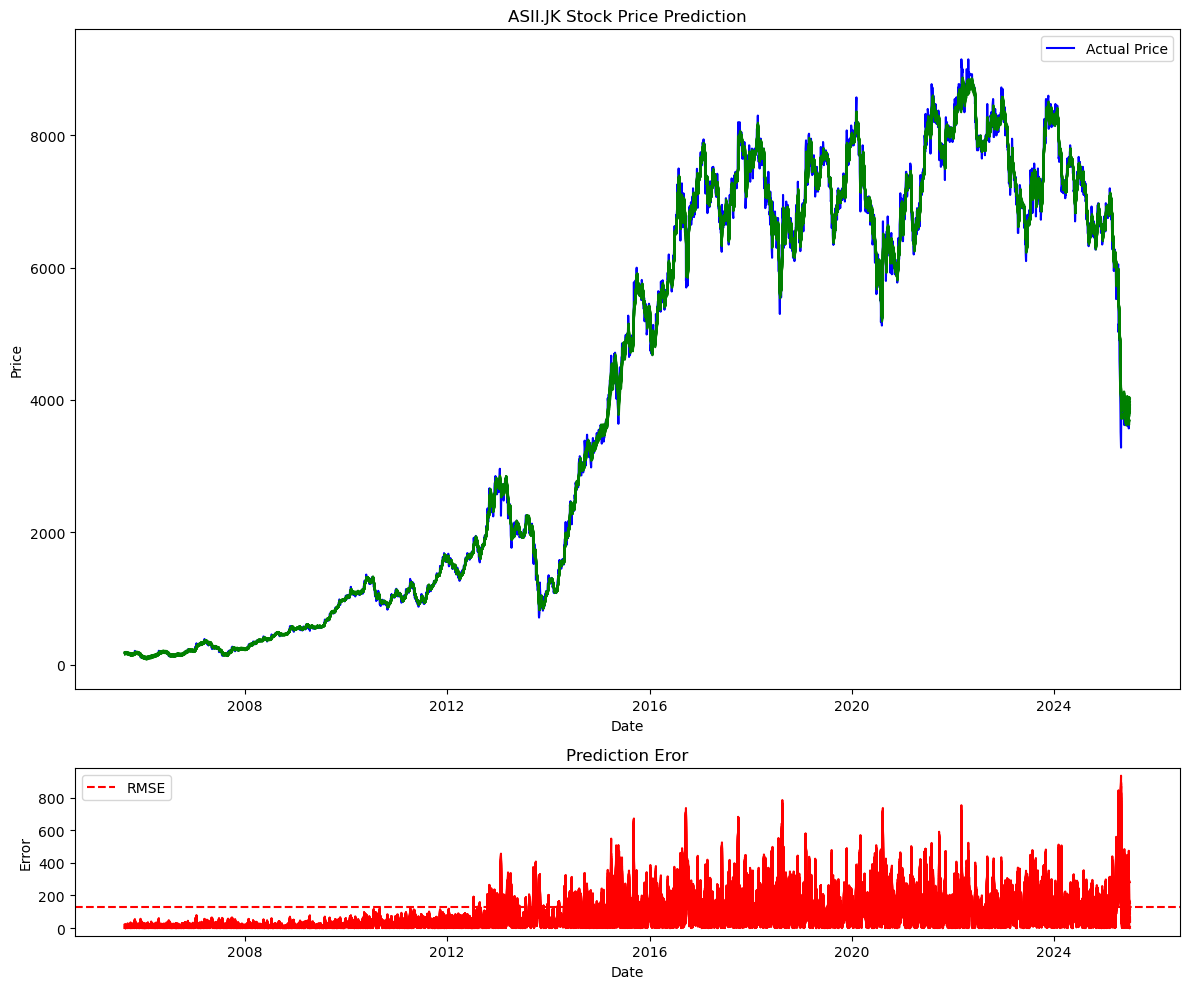

In [19]:
fig = plt.figure(figsize=(12, 10))

gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color = 'blue', label = "Actual Price")
ax1.legend()
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color = 'green')
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')


ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color = 'red', linestyle = '--', label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r')
ax2.legend()
plt.title('Prediction Eror')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()

plt.show()

## Conclusion

In this notebook, we implemented an LSTM-based model for stock price prediction, trained it on historical data, and evaluated its performance using RMSE. The model successfully captures the temporal dependencies in stock prices and can be used for making predictions based on past data.

### Key Takeaways:
- The LSTM model is effective for time series forecasting like stock prices.
- Evaluation metrics such as RMSE help in assessing the model's performance.
- Future improvements could involve hyperparameter tuning or using more advanced models like GRU or attention-based mechanisms.

Feel free to experiment with different stock tickers or time series data to explore the model’s potential!
